# Installation, data loading, and imports

In [1]:
!pisces_setup

Converting Mads Olsen model to Keras...
Model saved at /Users/eric/Engineering/Work/pisces/pisces/cached_models/mo_resunet.keras


In [2]:
import numpy as np
from typing import List
import tensorflow as tf
import pisces.models as pm
from importlib import reload
from matplotlib import pyplot as plt
from sklearn.model_selection import LeaveOneOut
from pisces.utils import pad_to_hat, plot_scores_CDF, plot_scores_PDF, add_rocs
from pisces.data_sets import DataSetObject, ModelInputSpectrogram, ModelOutputType, DataProcessor, PSGType
from importlib import reload
from scipy.special import softmax

import os
from pathlib import Path

CWD = Path(os.getcwd())
# NB! these are different from preprocess_data.ipynb
save_path = CWD.joinpath("fine_tuning")

hybrid_path = save_path.joinpath("hybrid")
os.makedirs(hybrid_path, exist_ok=True)
disordered_path = save_path.joinpath("disordered")
os.makedirs(disordered_path, exist_ok=True)
walch_path = save_path.joinpath("walch")
os.makedirs(walch_path, exist_ok=True)



In [3]:
MAX_PSG_EPOCHS = 1024
WASA_SLEEP_ACCURACY = 0.97
WASA_SLEEP_PERCENT = int(100 * WASA_SLEEP_ACCURACY)
WASA_COLUMN = f"WASA{int(WASA_SLEEP_ACCURACY*100)}"
AUROC_COLUMN = "AUROC"
ACCURACY_COLUMN = "WeightedAccuracy"
EVALUATION_COLUMNS = [WASA_COLUMN, ACCURACY_COLUMN, AUROC_COLUMN]

input_shape = (-1, 2048, 1)
output_shape = (-1, 1024, 1)

In [4]:
epochs = 15
break_up_line = "=" * 20

# TF Model Definitions

In [5]:
from dataclasses import dataclass
from sklearn.calibration import expit
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras import layers, models

# Custom loss function that takes weights into account
def weighted_binary_crossentropy(y_true, y_pred, sample_weight):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred, from_logits=True)[..., None]
    weighted_bce = bce * sample_weight
    return tf.reduce_mean(weighted_bce)

def make_mo_model():
    sampling_hz = 32 # Hz
    input_features = ['accelerometer']
    model_input = ModelInputSpectrogram(input_features, sampling_hz)
    output_type = ModelOutputType.WAKE_LIGHT_DEEP_REM
    mo = pm.MOResUNetPretrained(data_processor=None, sampling_hz=sampling_hz, lazy_model_loading=False)

    return mo

# Function to build the CNN-based mixture model
def build_smartmap_model(input_shape):
    inputs = tf.keras.Input(shape=input_shape)  # Input shape (1024, 4)

    # First 1D Convolutional Layer
    x = tf.keras.layers.Conv1D(filters=16, kernel_size=5, padding='same', activation='linear')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    # # Second 1D Convolutional Layer
    x = tf.keras.layers.Conv1D(filters=32, kernel_size=7, padding='same', activation='linear')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(negative_slope=0.1)(x)

    # x = tf.keras.layers.Dropout(0.1)(x)

    # Output Layer: Binary classification (Wake or Sleep)
    x = tf.keras.layers.Conv1D(filters=2, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=1, kernel_size=1, activation='linear')(x)

    # The output shape will be (1024, 1) per example, representing the probability of Sleep at each timestep
    return tf.keras.Model(inputs=inputs, outputs=x)

def cnn_pred_proba(cnn, data):
    return expit(
        cnn.predict(
            data.reshape(1, 1024, 4)
        )).reshape(-1,)

def naive_pred_proba(data):
    return 1 - softmax(data, axis=-1)[:, 0]

In [6]:

# Custom model class
class WeightedModel(tf.keras.Model):
    def __init__(self, original_model):
        super(WeightedModel, self).__init__()
        self.original_model = original_model

    def call(self, inputs):
        x = inputs
        return self.original_model(x)

    def train_step(self, data):
        x, y_true, sample_weight = data

        with tf.GradientTape() as tape:
            y_pred = self.original_model(x, training=True)
            loss = weighted_binary_crossentropy(y_true, y_pred, sample_weight)

        # Compute gradients and update weights
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics (includes the metric that tracks the loss)
        for metric in self.metrics:
            metric.update_state(y_true, y_pred)
        return {"loss": loss}

# Original model
def build_lr_cnn(kernel_size: int = 21):
    input_layer = layers.Input(shape=(2048, 1), name="activity_input")
    x = layers.Conv1D(filters=1, kernel_size=kernel_size, strides=2, padding="same")(input_layer)
    x = layers.BatchNormalization()(x)
    model = models.Model(inputs=input_layer, outputs=x)
    return model

def lr_cnn_pred_proba(lr_cnn, data: tf.Tensor):
    return expit(
        lr_cnn.predict(
            tf.reshape(data, (1, 2048, 1))
        )).reshape(-1,)
# Create original and weighted models
original_model = build_lr_cnn()
weighted_model = WeightedModel(original_model)

# Compile the model with an optimizer
weighted_model.compile(optimizer='adam', metrics=['auc'])

# Generate dummy data
N_SAMPLES = 5
x_data = tf.random.normal((N_SAMPLES, 2048, 1), dtype=tf.float32)
y_data = tf.random.normal((N_SAMPLES, 1024, 1), dtype=tf.float32)
sample_weights = tf.random.normal((N_SAMPLES, 1024, 1), dtype=tf.float32)

# Train the model using a dataset
dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data, sample_weights))
dataset = dataset.batch(1)

# Fit the model
weighted_model.fit(dataset, epochs=2, validation_data=None)


Epoch 1/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.011726
Epoch 2/2
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 925us/step - loss: 0.0109


# Weighting and analysis functions

In [7]:
import json
from dataclasses import dataclass

import pandas as pd
from sklearn.metrics import auc, roc_curve
from sklearn.utils import class_weight
import numpy as np

def compute_sample_weights(labels: np.ndarray, verbose: bool = False) -> np.ndarray:
    mask_weights = labels >= 0
    if verbose:
        print(f"Scored % of {labels.size} epochs:\n{100 * (np.sum(mask_weights) / mask_weights.size):.2f} ({np.sum(mask_weights)} / {mask_weights.size})")

    class_weight_array = class_weight.compute_class_weight(
        class_weight='balanced',
        classes=np.array([0, 1]),
        y=labels[mask_weights].flatten()
    )
    class_weights = {0: class_weight_array[0], 1: class_weight_array[1]}
    if verbose:
        print("Class weights:\n", json.dumps(class_weights, indent=2)) # pretty print
    class_weights |= {-1: 0.0}

    def weight_fn(x):
        return class_weights[x]
    
    wfv = np.vectorize(weight_fn)
    sample_weights = wfv(labels)

    return sample_weights

def masked_weighted_accuracy(y_true, y_pred, sample_weight):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    sample_weight = tf.cast(sample_weight, tf.float32)
    correct = tf.cast(tf.equal(y_true, y_pred), tf.float32)
    weighted_accuracy = tf.reduce_sum(correct * sample_weight) / tf.reduce_sum(sample_weight)

    return weighted_accuracy.numpy()



def auroc_balaccuracy_wasa(split_name, binary_pred_proba, test_sample_weights, test_labels_masked, sleep_accuracy=WASA_SLEEP_ACCURACY):

    flat_test_labels = test_labels_masked.reshape(-1,)
    flat_weights = test_sample_weights.reshape(-1,)

    # # compute AUROC
    fpr, tpr, thresholds = roc_curve(flat_test_labels, binary_pred_proba, sample_weight=flat_weights)
    roc_auc = auc(fpr, tpr)

    # # compute WASA
    wasa_threshold = thresholds[np.sum(tpr <= sleep_accuracy)]
    y_guess = binary_pred_proba > wasa_threshold
    guess_right = y_guess == flat_test_labels
    y_wake = (flat_test_labels == 0) & (flat_weights > 0)
    n_wake = np.sum(y_wake)
    n_wake_right = np.sum(y_wake & guess_right)
    wake_accuracy = n_wake_right / n_wake

    weighted_accuracy = masked_weighted_accuracy(
        flat_test_labels,
        y_guess,
        flat_weights)

    print("=" * 20)
    print(f"Fold {split_name}")
    print(f"\tROC AUC: {roc_auc}")
    print(f"\tWEIGHTED accuracy @ ≧{WASA_SLEEP_PERCENT}% sleep: {weighted_accuracy}")
    print(f"\t{WASA_COLUMN}: {wake_accuracy} ({n_wake_right} / {n_wake} || threshold: {wasa_threshold})")
    print("=" * 20)
    return roc_auc, weighted_accuracy, wake_accuracy


def evaluate_auroc_wasa_balanced_accuracy(
        predictors,  # list of models, pretty flexible as predictors[i] is passed to evaluators[i] with preprocessed_data[i]
        evaluators,  # list of functions that take (predictor, sample) -> probability of sleep
        preprocessed_data):
    keys = list(preprocessed_data.keys())
    evaluations = []
    for eval_fn, predictor, split_name in zip(evaluators, predictors, keys):
        test_data, test_labels, test_specgrams = preprocessed_data[split_name]
        test_sample_weights = compute_sample_weights(test_labels)
        evaluations.append(
            auroc_balaccuracy_wasa(
            split_name, 
            eval_fn(predictor, test_data),
            test_data, 
            test_sample_weights, 
            test_labels
            )
        )
    evaluations_df = pd.DataFrame(evaluations, columns=EVALUATION_COLUMNS)

    return evaluations_df


@dataclass
class PreparedData:
    activity: tf.Tensor 
    spectrogram: tf.Tensor 
    mo_predictions: tf.Tensor 
    true_labels: tf.Tensor 
    sample_weights: tf.Tensor 


def prepare_data(preprocessed_data: dict):
    mo = make_mo_model()
    keys = list(preprocessed_data.keys())
    xyz_specgram_input = np.array([
        preprocessed_data[k]['spectrogram']
        for k in keys
    ])
    xyz_average = xyz_specgram_input #np.mean(xyz_specgram_input, axis=-1)

    specgram_input = np.zeros((*xyz_average.shape, 2))
    # embed x,y,z into 2 channels
    # one is reflected along the frequency axis
    specgram_input[..., 0] = xyz_average
    specgram_input[..., 1] = xyz_average[..., ::-1]
    
    mo_predictions = mo.predict_logits(specgram_input)

    full_labels = np.array([
        preprocessed_data[k]['psg'][:, 1]
        for k in keys
    ])
    labels = np.where(full_labels > 0, 1, full_labels)

    # in original setup, specgrams were average of x,y,z
    # specgrams = np.mean(xyz_specgram_input, axis=-1)
    specgrams = xyz_specgram_input

    activity = np.array([
        preprocessed_data[k]['activity'][:, 1]
        for k in keys
    ])
    weights = np.array([
        compute_sample_weights(labels[i])
        for i in range(labels.shape[0])
    ])
    return PreparedData(
        activity=tf.convert_to_tensor(activity, dtype=tf.float32),
        spectrogram=tf.convert_to_tensor(specgrams, dtype=tf.float32),
        mo_predictions=tf.convert_to_tensor(mo_predictions, dtype=tf.float32),
        true_labels=tf.convert_to_tensor(labels, dtype=tf.float32),
        sample_weights=tf.convert_to_tensor(weights, dtype=tf.float32)
    )


# Plotting functions

In [8]:
from matplotlib import rcParams
import seaborn as sns

color_palette = sns.color_palette("colorblind")

def tri_plot_metrics(evaluations_df: List[tuple], save_dir: Path | None = None, PLOT_TITLE: str = "Metrics", axs: List[plt.Axes] | None = None, axs_set_name: str | None = None, filename: str | None = None):
    if axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig = axs[0].figure

    metrics = {
        'sw_accuracy': evaluations_df[ACCURACY_COLUMN],
        'auc': evaluations_df[WASA_COLUMN],
        'wasa': evaluations_df[AUROC_COLUMN]
    }

    rcParams['font.family'] = 'Helvetica'
    rcParams['font.size'] = 12  # Set a global font size

    metrics_dimensions = {'sw_accuracy': f'B.Acc{WASA_SLEEP_PERCENT}', 'auc': 'AUC', 'wasa': WASA_COLUMN}
    metric_colors = {'sw_accuracy': color_palette[4], 'auc': color_palette[1], 'wasa': color_palette[2]}

    if axs_set_name is not None:
        axs[0].set_title(axs_set_name)

    for metric, ax in zip(metrics_dimensions.keys(), axs):
        sns.histplot(metrics[metric], bins=20, kde=True, color=metric_colors[metric], ax=ax)
        ax.axvline(np.mean(metrics[metric]), color='red', linestyle='dashed', linewidth=2, label=f"Mean {metrics_dimensions[metric]}: {np.mean(metrics[metric]):.5f}")
        # ax.set_title(metrics_dimensions[metric])
        ax.set_xlabel(metrics_dimensions[metric])
        ax.set_xlim(0, 1)

        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Customize the remaining spines (left and bottom)
        ax.spines['left'].set_linewidth(1.2)
        ax.spines['bottom'].set_linewidth(1.2)

        ax.set_ylabel('Count')
        ax.legend()

    fig.suptitle(PLOT_TITLE,
                 fontsize=20)
    fig.tight_layout()
    if save_dir is not None:
        if filename is None:
            filename = 'tri_plot_metrics.png'
        fig.savefig(save_dir.joinpath(filename), dpi=600, bbox_inches='tight')

In [9]:
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import auc, roc_curve

def add_spectrogram(ax, specgram):
    ax.imshow(specgram.T, aspect='auto', origin='lower', vmax=20, vmin=-20)
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'Specgram')
    ax.set_ylabel('Frequency')

def add_smartmap_inputs(ax, input_data):
    input_t = input_data.T
    INPUT_EPOCHS = input_data.shape[0]
    ax.stackplot(range(INPUT_EPOCHS), softmax(input_t, axis=0))
    ax.set_xlim(0, INPUT_EPOCHS)
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'SmartMap Training Input')
    ax.set_ylabel('Value')
    ax.set_xlabel('Time (epochs)')

def add_lr_inputs(ax, input_data):
    cnn_input_width = input_data.shape[0]
    ax.plot(range(cnn_input_width), input_data)
    ax.set_xlim(0, cnn_input_width)
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'Actigraphy')
    ax.set_ylabel('Value')
    ax.set_xlabel('Time (epochs)')

def add_hypnogram(ax, binary_pred_proba, true_labels, naive_prediction, model_type):
    binary_label = 'SmartMap Prediction' if model_type == 'smartmap' else 'LR Prediction'
    ax.plot(binary_pred_proba, label=binary_label)
    if naive_prediction is not None:
        ax.plot(naive_prediction, label='Naive: 1 - P(wake)')

    sample_weight = compute_sample_weights(true_labels)
    masked_true_labels = np.where(sample_weight, true_labels, -1)

    ax.plot(masked_true_labels, label='Actual', linestyle='--')
    ax.set_xlim(0, len(binary_pred_proba))
    ax.set_ylabel('Probability of Sleep')
    # Create a secondary y-axis on the right and set its label
    secax = ax.secondary_yaxis('right')
    secax.set_ylabel(f'Hypnogram')
    ax.legend()

    return masked_true_labels, sample_weight


def add_roc(ax, binary_pred_proba, true_labels, sample_weight, naive_prediction: np.ndarray | None = None):
    masked_true_labels = np.where(sample_weight, true_labels, 0)
    fpr, tpr, thresholds = roc_curve(masked_true_labels, binary_pred_proba, sample_weight=sample_weight)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')

    roc_auc_naive = None
    if naive_prediction is not None:
        # Plot the ROC curve from naive_prediction
        fpr_naive, tpr_naive, _ = roc_curve(masked_true_labels, naive_prediction, sample_weight=sample_weight)
        roc_auc_naive = auc(fpr_naive, tpr_naive)
        ax.plot(fpr_naive, tpr_naive, color='green', lw=2, label=f'Naive ROC curve (area = {roc_auc_naive:.2f})')
    ax.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('Wake Predicted as Sleep')
    ax.set_ylabel('Sleep Predicted as Sleep')
    ax.legend(loc="lower right")

    return roc_auc, roc_auc_naive

from typing import List
def ranked_debug_plots(df, eval_data, true_labels, predictors, evaluator, specgrams, filename_suffix: str, model_type: str, split_names: List[str] = None):
    indices = df.sort_values(ACCURACY_COLUMN, ascending=False).index
    aurocs = []
    

    for rank, idx in enumerate(indices):
        if idx >= len(eval_data):
            continue
        fig, axs = plt.subplots(4, 1, figsize=(10, 15))
        fig.subplots_adjust(hspace=0, left=0)
        
        # Plot the specgram
        _ = add_spectrogram(axs[0], specgrams[idx])
        
        # Plot the CNN training input as a stacked area plot
        if model_type == 'smartmap':
            add_smartmap_inputs(axs[1], eval_data[idx].squeeze(), )
        elif model_type == 'lr':
            add_lr_inputs( axs[1], eval_data[idx].squeeze(),)
        
        # Plot the final output along with the correct value

        binary_pred_proba = evaluator(predictors[idx], eval_data[idx]).squeeze()
        naive_prediction = 1 - eval_data[idx][:, 0] if model_type == 'smartmap' else None
        masked_true_labels, sample_weight = add_hypnogram(
            axs[2],
            binary_pred_proba,
            true_labels[idx],
            naive_prediction,
            model_type
        )

        auroc, *_ = add_roc(
            ax=axs[3], 
            binary_pred_proba=binary_pred_proba, 
            true_labels=true_labels[idx], 
            sample_weight=sample_weight, 
            naive_prediction=naive_prediction
        )

        aurocs.append(auroc)

        if split_names is None:
            split_names = [f"split {i}" for i in range(len(eval_data))]
        fig.suptitle(f'#{rank} {split_names[idx]} Weighted Accuracy: {df.loc[idx, ACCURACY_COLUMN]} {WASA_COLUMN}: {df.loc[idx, WASA_COLUMN]}',
                    fontsize=16, fontweight='bold')
        
        fig.tight_layout(pad=0.1)
        plt.savefig(walch_path.joinpath(f"{split_names[idx]}_rank_{rank}_{filename_suffix}.png"))
        plt.close()

    sns.histplot(aurocs, bins=20, kde=True, color='blue', ax=plt.gca(), )
    plt.xlabel('AUROC')
    plt.ylabel('Count')
    plt.title('Distribution of AUROCs')
    plt.show()


# Arcascope's SmartMap

In [10]:
dataset = "walch"
walch_preprocessed_data = np.load('./pre_processed_data/walch/walch_preprocessed_data.npy',
                                   allow_pickle=True).item()

In [11]:
walch_preprocessed_data['1818471'].keys()

dict_keys(['spectrogram', 'activity', 'psg'])

In [12]:
walch_preprocessed_data.keys()

dict_keys(['1066528', '1360686', '1449548', '1455390', '1818471', '2598705', '2638030', '3997827', '4018081', '4314139', '4426783', '46343', '5498603', '5797046', '6220552', '781756', '8000685', '8173033', '844359', '8530312', '8686948', '8692923', '9106476', '9618981'])

In [13]:

split_maker = pm.LeaveOneOutSplitter()

## Create data tensors for training + evaluating

In [14]:
walch_preprocessed_data.keys()

dict_keys(['1066528', '1360686', '1449548', '1455390', '1818471', '2598705', '2638030', '3997827', '4018081', '4314139', '4426783', '46343', '5498603', '5797046', '6220552', '781756', '8000685', '8173033', '844359', '8530312', '8686948', '8692923', '9106476', '9618981'])

In [15]:
walch_preprocessed_data['1066528']['spectrogram'].shape

(15360, 32)

In [16]:
walch_keys = list(walch_preprocessed_data.keys())
walch_data_bundle = prepare_data(walch_preprocessed_data)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [17]:
walch_data_bundle.mo_predictions.shape

TensorShape([24, 1024, 4])

In [18]:
walch_data_bundle.spectrogram.shape

TensorShape([24, 15360, 32])

## Training

In [19]:
import pandas as pd
from sklearn.calibration import expit
from sklearn.metrics import auc, roc_curve
from tqdm import tqdm

SHAPE = (MAX_PSG_EPOCHS, 4)
split_maker = pm.LeaveOneOutSplitter()

training_results = []
evaluations = []
cnn_predictors = []

print("Training models...")
print("Saving models to", walch_path)

# Split the data into training and testing sets
for k_train, k_test in tqdm(split_maker.split(walch_keys), desc="Next split", total=len(walch_keys)):
    # Convert indices to tensors
    train_idx_tensor = tf.constant(k_train, dtype=tf.int32)
    test_idx_tensor = tf.constant(k_test, dtype=tf.int32)

    # Gather the training and validation data using tf.gather
    # training
    train_data = tf.reshape(
        tf.gather(walch_data_bundle.mo_predictions, train_idx_tensor),
        (-1, *SHAPE))
    train_labels = tf.reshape(
        tf.gather(walch_data_bundle.true_labels, train_idx_tensor),
        output_shape)
    train_sample_weights = tf.reshape(
        tf.gather(walch_data_bundle.sample_weights, train_idx_tensor),
        output_shape)
    # testing
    test_data = tf.reshape(
        tf.gather(walch_data_bundle.mo_predictions, test_idx_tensor),
        (-1, *SHAPE))
    test_labels = tf.reshape(
        tf.gather(walch_data_bundle.true_labels, test_idx_tensor),
        output_shape)
    test_sample_weights = tf.reshape(
        tf.gather(walch_data_bundle.sample_weights, test_idx_tensor),
        output_shape)

    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights, we can just set the labels to 0
    train_labels_masked = tf.where(train_sample_weights > 0, train_labels, 0.0)
    test_labels_masked = tf.where(test_sample_weights > 0, test_labels, 0.0)

    # Train the model on the training set
    cnn = build_smartmap_model(SHAPE)
    cnn.compile(
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.AdamW(learning_rate=5e-4),
    )

    # gives weight 0 to -1 "mask" intervals, 1 to the rest


    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights,
    # we can just set the labels to 0
    train_labels_masked = np.where(train_sample_weights, train_labels, 0)

    training_results.append(cnn.fit(
        train_data, train_labels_masked, 
        epochs=100, 
        validation_split=0.0, 
        callbacks=[],
        batch_size=1,
        sample_weight=train_sample_weights,
        verbose=0,
    ))

    # Evaluate the model on the testing set

    accuracy_metrics = auroc_balaccuracy_wasa(
        walch_keys[k_test[0]],
        cnn_pred_proba(cnn, test_data.numpy()),
        test_sample_weights.numpy(),
        test_labels_masked.numpy())

    # # Save all the results
    evaluations.append(accuracy_metrics)

    cnn_predictors.append(cnn)
    # cnn.save(walch_path.joinpath(f"{k_test[0]}_cnn.h5"))


evaluations_df = pd.DataFrame(evaluations, columns=EVALUATION_COLUMNS)


Training models...
Saving models to /Users/eric/Engineering/Work/pisces/analyses/NHRC/fine_tuning/walch


Next split:   0%|          | 0/24 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Next split:   4%|▍         | 1/24 [00:05<01:59,  5.19s/it]

Fold 1066528
	ROC AUC: 0.7949642051583798
	WEIGHTED accuracy @ ≧97% sleep: 0.5869006514549255
	WASA97: 0.20454545454545456 (27 / 132 || threshold: 0.06934630870819092)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Next split:   8%|▊         | 2/24 [00:10<01:54,  5.21s/it]

Fold 1360686
	ROC AUC: 0.9541450347950955
	WEIGHTED accuracy @ ≧97% sleep: 0.8200389742851257
	WASA97: 0.6704545454545454 (59 / 88 || threshold: 0.14425307512283325)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Next split:  12%|█▎        | 3/24 [00:15<01:49,  5.24s/it]

Fold 1449548
	ROC AUC: 0.8791199158485273
	WEIGHTED accuracy @ ≧97% sleep: 0.6699976325035095
	WASA97: 0.3695652173913043 (34 / 92 || threshold: 0.09668109565973282)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


Next split:  17%|█▋        | 4/24 [00:20<01:44,  5.23s/it]

Fold 1455390
	ROC AUC: 0.7601005747126437
	WEIGHTED accuracy @ ≧97% sleep: 0.6987067461013794
	WASA97: 0.425 (34 / 80 || threshold: 0.349305659532547)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  21%|██        | 5/24 [00:26<01:38,  5.18s/it]

Fold 1818471
	ROC AUC: 0.9882911392405064
	WEIGHTED accuracy @ ≧97% sleep: 0.9378690719604492
	WASA97: 0.9 (9 / 10 || threshold: 0.025680972263216972)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Next split:  25%|██▌       | 6/24 [00:31<01:33,  5.18s/it]

Fold 2598705
	ROC AUC: 0.9676640926640927
	WEIGHTED accuracy @ ≧97% sleep: 0.8436294198036194
	WASA97: 0.7142857142857143 (10 / 14 || threshold: 0.01595633663237095)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Next split:  29%|██▉       | 7/24 [00:36<01:27,  5.16s/it]

Fold 2638030
	ROC AUC: 0.9541709780734171
	WEIGHTED accuracy @ ≧97% sleep: 0.8763045072555542
	WASA97: 0.7804878048780488 (96 / 123 || threshold: 0.29936373233795166)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  33%|███▎      | 8/24 [00:41<01:22,  5.14s/it]

Fold 3997827
	ROC AUC: 0.9967276641550054
	WEIGHTED accuracy @ ≧97% sleep: 0.9735414385795593
	WASA97: 0.96 (24 / 25 || threshold: 0.14187414944171906)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Next split:  38%|███▊      | 9/24 [00:46<01:16,  5.08s/it]

Fold 4018081
	ROC AUC: 0.954837525243253
	WEIGHTED accuracy @ ≧97% sleep: 0.9075636863708496
	WASA97: 0.8461538461538461 (55 / 65 || threshold: 0.316516637802124)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  42%|████▏     | 10/24 [00:51<01:11,  5.09s/it]

Fold 4314139
	ROC AUC: 0.8630057871598128
	WEIGHTED accuracy @ ≧97% sleep: 0.7587250471115112
	WASA97: 0.5454545454545454 (54 / 99 || threshold: 0.4819798171520233)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Next split:  46%|████▌     | 11/24 [00:56<01:06,  5.13s/it]

Fold 4426783
	ROC AUC: 0.9429791205752212
	WEIGHTED accuracy @ ≧97% sleep: 0.862831711769104
	WASA97: 0.75 (48 / 64 || threshold: 0.31130093336105347)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Next split:  50%|█████     | 12/24 [01:01<01:01,  5.08s/it]

Fold 46343
	ROC AUC: 0.9129038352541092
	WEIGHTED accuracy @ ≧97% sleep: 0.9059945940971375
	WASA97: 0.8354430379746836 (66 / 79 || threshold: 0.6701414585113525)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Next split:  54%|█████▍    | 13/24 [01:06<00:55,  5.05s/it]

Fold 5498603
	ROC AUC: 0.9457601453664446
	WEIGHTED accuracy @ ≧97% sleep: 0.6677317023277283
	WASA97: 0.36538461538461536 (38 / 104 || threshold: 0.0075056347995996475)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


Next split:  58%|█████▊    | 14/24 [01:11<00:50,  5.05s/it]

Fold 5797046
	ROC AUC: 0.8990158005513887
	WEIGHTED accuracy @ ≧97% sleep: 0.7321985363960266
	WASA97: 0.4936708860759494 (39 / 79 || threshold: 0.47811293601989746)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Next split:  62%|██████▎   | 15/24 [01:16<00:45,  5.02s/it]

Fold 6220552
	ROC AUC: 0.894584512477489
	WEIGHTED accuracy @ ≧97% sleep: 0.7316056489944458
	WASA97: 0.5 (26 / 52 || threshold: 0.261403888463974)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Next split:  67%|██████▋   | 16/24 [01:21<00:40,  5.02s/it]

Fold 781756
	ROC AUC: 0.8832777582777583
	WEIGHTED accuracy @ ≧97% sleep: 0.7196898460388184
	WASA97: 0.4675324675324675 (36 / 77 || threshold: 0.04871746152639389)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  71%|███████   | 17/24 [01:26<00:34,  4.97s/it]

Fold 8000685
	ROC AUC: 0.9496940733499873
	WEIGHTED accuracy @ ≧97% sleep: 0.8408095240592957
	WASA97: 0.7096774193548387 (22 / 31 || threshold: 0.17635591328144073)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


Next split:  75%|███████▌  | 18/24 [01:31<00:29,  4.95s/it]

Fold 8173033
	ROC AUC: 0.97219313336824
	WEIGHTED accuracy @ ≧97% sleep: 0.9196462035179138
	WASA97: 0.8620689655172413 (25 / 29 || threshold: 0.13817337155342102)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Next split:  79%|███████▉  | 19/24 [01:36<00:24,  4.94s/it]

Fold 844359
	ROC AUC: 0.8805013394565634
	WEIGHTED accuracy @ ≧97% sleep: 0.7591778635978699
	WASA97: 0.5494505494505495 (50 / 91 || threshold: 0.039273034781217575)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Next split:  83%|████████▎ | 20/24 [01:41<00:19,  5.00s/it]

Fold 8530312
	ROC AUC: 0.9033757421543681
	WEIGHTED accuracy @ ≧97% sleep: 0.7313995361328125
	WASA97: 0.49333333333333335 (37 / 75 || threshold: 0.03234060853719711)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Next split:  88%|████████▊ | 21/24 [01:46<00:14,  4.99s/it]

Fold 8686948
	ROC AUC: 0.9941335024575868
	WEIGHTED accuracy @ ≧97% sleep: 0.981471836566925
	WASA97: 0.9795918367346939 (48 / 49 || threshold: 0.13551808893680573)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Next split:  92%|█████████▏| 22/24 [01:51<00:09,  4.97s/it]

Fold 8692923
	ROC AUC: 0.9547450110864746
	WEIGHTED accuracy @ ≧97% sleep: 0.924445629119873
	WASA97: 0.8818181818181818 (97 / 110 || threshold: 0.5208896398544312)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


Next split:  96%|█████████▌| 23/24 [01:56<00:04,  4.92s/it]

Fold 9106476
	ROC AUC: 0.7267281105990784
	WEIGHTED accuracy @ ≧97% sleep: 0.6332340836524963
	WASA97: 0.29411764705882354 (25 / 85 || threshold: 0.3659960627555847)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


Next split: 100%|██████████| 24/24 [02:00<00:00,  5.04s/it]

Fold 9618981
	ROC AUC: 0.9118477676169986
	WEIGHTED accuracy @ ≧97% sleep: 0.7067979574203491
	WASA97: 0.4431818181818182 (39 / 88 || threshold: 0.17788878083229065)


## Ranked specgram + prediction plots
1. Spectrogram
2. Staging probabilities
3. Hypnogram with CNN and naive binarization
4. ROC curve

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


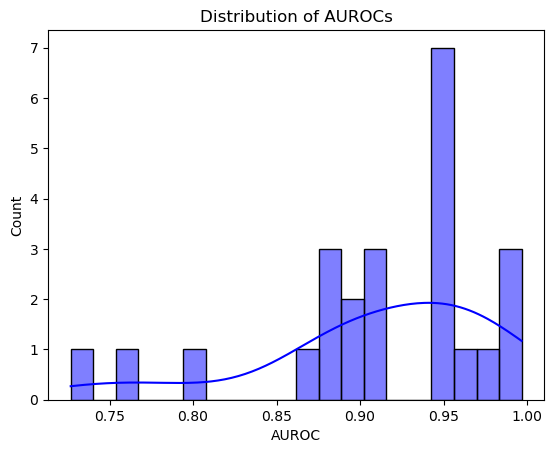

In [20]:
ranked_debug_plots(
    evaluations_df,
    walch_data_bundle.mo_predictions.numpy(),
    walch_data_bundle.true_labels.numpy(),
    cnn_predictors,
    cnn_pred_proba,
    walch_data_bundle.spectrogram.numpy(),
    "_cnn_eval_stationary",
    "smartmap",
    walch_keys
)

## Hybrid data set

In [21]:
dataset = "hybrid"
hybrid_preprocessed_data = np.load(f'./pre_processed_data/{dataset}/{dataset}_preprocessed_data.npy',
                                   allow_pickle=True).item()

In [22]:
hybrid_keys = list(hybrid_preprocessed_data.keys())
hybrid_data_bundle = prepare_data(hybrid_preprocessed_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [23]:

# Import necessary libraries
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import auc, roc_curve

results = []
for idx in range(len(hybrid_preprocessed_data)):
    hybrid_weights = hybrid_data_bundle.sample_weights[idx].numpy()
    hybrid_labels = hybrid_data_bundle.true_labels[idx].numpy()
    hybrid_labels_masked = np.where(hybrid_weights, hybrid_labels, 0)

    eval = auroc_balaccuracy_wasa(
        hybrid_keys[idx], 
        cnn_pred_proba(cnn_predictors[idx],
        hybrid_data_bundle.mo_predictions[idx].numpy()),
        hybrid_weights,
        hybrid_labels_masked)
    results.append(eval)

evaluations_df_hybrid = pd.DataFrame(results, columns=EVALUATION_COLUMNS)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1066528
	ROC AUC: 0.6218945421806944
	WEIGHTED accuracy @ ≧97% sleep: 0.54720538854599
	WASA97: 0.12030075187969924 (16 / 133 || threshold: 0.04818325489759445)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1360686
	ROC AUC: 0.9668054942630185
	WEIGHTED accuracy @ ≧97% sleep: 0.8677184581756592
	WASA97: 0.75 (66 / 88 || threshold: 0.1465386003255844)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1449548
	ROC AUC: 0.8657214706902533
	WEIGHTED accuracy @ ≧97% sleep: 0.6202957034111023
	WASA97: 0.26881720430107525 (25 / 93 || threshold: 0.08348284661769867)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1455390
	ROC AUC: 0.7435362565630764
	WEIGHTED accuracy @ ≧97% sleep: 0.7196251153945923
	WASA97: 0.4691358024691358 (38 / 81 || threshold: 0.6000179052352905)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 1818471
	ROC AUC: 0.9968354430379747
	WEIGHTED accuracy @ ≧97% sleep: 0.9941982626914978
	WASA97: 1.0 (10 / 10 || threshold: 0.07584886997938156)
1/1 ━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


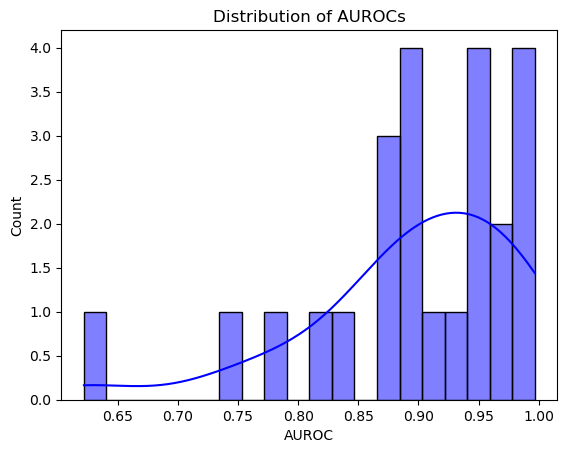

In [24]:
ranked_debug_plots(
    evaluations_df_hybrid,
    hybrid_data_bundle.mo_predictions.numpy(),
    hybrid_data_bundle.true_labels.numpy(),
    cnn_predictors,
    cnn_pred_proba,
    hybrid_data_bundle.spectrogram.numpy(),
    "_cnn_eval_hybrid",
    "smartmap",
    walch_keys
)

# Naive
Just take the (W, L, D, M) probability and set the prob of sleep to be 1 - (W,)

In [25]:

results = []
for idx in range(len(hybrid_preprocessed_data)):
    hybrid_weights = walch_data_bundle.sample_weights[idx].numpy()
    hybrid_labels = walch_data_bundle.true_labels[idx].numpy()
    hybrid_labels_masked = np.where(hybrid_weights, hybrid_labels, 0)
    hybrid_wldm_predictions = hybrid_data_bundle.mo_predictions[idx].numpy()
    hybrid_binary = naive_pred_proba(hybrid_wldm_predictions)

    eval = auroc_balaccuracy_wasa(
        hybrid_keys[idx], 
        hybrid_binary,
        hybrid_weights,
        hybrid_labels_masked)
    results.append(eval)

evaluations_df_naive_hybrid = pd.DataFrame(results, columns=EVALUATION_COLUMNS)

Fold 1066528
	ROC AUC: 0.6499215455526135
	WEIGHTED accuracy @ ≧97% sleep: 0.5460430383682251
	WASA97: 0.12121212121212122 (16 / 132 || threshold: 0.6418489217758179)
Fold 1360686
	ROC AUC: 0.9752982436761295
	WEIGHTED accuracy @ ≧97% sleep: 0.9070888161659241
	WASA97: 0.8409090909090909 (74 / 88 || threshold: 0.6924972534179688)
Fold 1449548
	ROC AUC: 0.9044968443197756
	WEIGHTED accuracy @ ≧97% sleep: 0.6434958577156067
	WASA97: 0.31521739130434784 (29 / 92 || threshold: 0.6719006896018982)
Fold 1455390
	ROC AUC: 0.7734913793103448
	WEIGHTED accuracy @ ≧97% sleep: 0.6674566268920898
	WASA97: 0.3625 (29 / 80 || threshold: 0.7673211097717285)
Fold 1818471
	ROC AUC: 0.9971518987341772
	WEIGHTED accuracy @ ≧97% sleep: 0.9926159977912903
	WASA97: 1.0 (10 / 10 || threshold: 0.6755151748657227)
Fold 2598705
	ROC AUC: 0.8802123552123553
	WEIGHTED accuracy @ ≧97% sleep: 0.5599417686462402
	WASA97: 0.14285714285714285 (2 / 14 || threshold: 0.5310819149017334)
Fold 2638030
	ROC AUC: 0.930012318

In [26]:

# Import necessary libraries
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import auc, roc_curve

results = []
for idx in range(len(hybrid_preprocessed_data)):
    walch_weights = walch_data_bundle.sample_weights[idx].numpy()
    walch_labels = walch_data_bundle.true_labels[idx].numpy()
    walch_labels_masked = np.where(walch_weights, walch_labels, 0)
    walch_wldm_predictions = walch_data_bundle.mo_predictions[idx].numpy()
    walch_binary = naive_pred_proba(walch_wldm_predictions)

    eval = auroc_balaccuracy_wasa(
        walch_keys[idx], 
        walch_binary,
        walch_weights,
        walch_labels_masked)
    results.append(eval)

evaluations_df_naive_walch = pd.DataFrame(results, columns=EVALUATION_COLUMNS)

Fold 1066528
	ROC AUC: 0.745133372560557
	WEIGHTED accuracy @ ≧97% sleep: 0.5528097152709961
	WASA97: 0.13636363636363635 (18 / 132 || threshold: 0.5791138410568237)
Fold 1360686
	ROC AUC: 0.9747735557273832
	WEIGHTED accuracy @ ≧97% sleep: 0.8882207870483398
	WASA97: 0.8068181818181818 (71 / 88 || threshold: 0.6794447898864746)
Fold 1449548
	ROC AUC: 0.8776151238896681
	WEIGHTED accuracy @ ≧97% sleep: 0.6591281294822693
	WASA97: 0.34782608695652173 (32 / 92 || threshold: 0.6487358808517456)
Fold 1455390
	ROC AUC: 0.7198132183908046
	WEIGHTED accuracy @ ≧97% sleep: 0.659482479095459
	WASA97: 0.35 (28 / 80 || threshold: 0.7344871759414673)
Fold 1818471
	ROC AUC: 0.9806962025316455
	WEIGHTED accuracy @ ≧97% sleep: 0.9394513368606567
	WASA97: 0.9 (9 / 10 || threshold: 0.6118409037590027)
Fold 2598705
	ROC AUC: 0.8693050193050194
	WEIGHTED accuracy @ ≧97% sleep: 0.6987450122833252
	WASA97: 0.42857142857142855 (6 / 14 || threshold: 0.5456297397613525)
Fold 2638030
	ROC AUC: 0.92401084010840

# Log Reg

## Preprocessing

In [27]:
# import pisces.data_sets as pds
# pisces_data_location = '/Users/eric/Engineering/Work/pisces/data_sets'

# sets = pds.DataSetObject.find_data_sets(pisces_data_location)

# walch_data = sets['walch_et_al']
# walch_data.parse_data_sets()

# print(f"Found {len(walch_data.ids)} subjects (should be 31)")

# hybrid = sets['hybrid_motion']
# hybrid.parse_data_sets()

# print(f"Found {len(hybrid.ids)} subjects (should be 31)")
# log_reg_hyperparameters = {'penalty': None, 'alpha': 10.0, 'fit_intercept': False, 'learning_rate': 'adaptive', 'eta0': 0.0001, 'random_state': 42}
# output_type = pm.ModelOutputType.SLEEP_WAKE
# model_input = pm.ModelInput1D(
#     ['activity'],
#     1/15,
#     300)
# walch_data_processor = pds.DataProcessor(walch_data, model_input, output_type=output_type)

# def make_lr_model():
#     return pm.SGDLinearClassifier(walch_data_processor, **log_reg_hyperparameters)

# swc = make_lr_model()

# ids_to_preprocess_walch = [i for i in walch_data.ids if i not in subjects_to_exclude_walch]
# preprocessed_data_walch = {i: swc.get_needed_X_y(i) for i in ids_to_preprocess_walch}
# ids_to_preprocess_hybrid = [i for i in hybrid.ids if i not in subjects_to_exclude_hybrid]
# preprocessed_data_hybrid= {i: swc.get_needed_X_y(i) for i in ids_to_preprocess_hybrid}


## LR as a CNN model

## Train LR CNN

In [28]:

split_maker = pm.LeaveOneOutSplitter()

training_results = []
evaluations = []
predictors = []

print("Training models...")
print("Saving models to", walch_path)

# Split the data into training and testing sets
for k_train, k_test in tqdm(split_maker.split(walch_keys), desc="Next split", total=len(walch_keys)):
    # Convert indices to tensors
    train_idx_tensor = tf.constant(k_train, dtype=tf.int32)
    test_idx_tensor = tf.constant(k_test, dtype=tf.int32)

    # Gather the training and validation data using tf.gather
    # training
    train_data = tf.reshape(
        tf.gather(walch_data_bundle.activity, train_idx_tensor),
        input_shape)
    train_labels = tf.reshape(
        tf.gather(walch_data_bundle.true_labels, train_idx_tensor),
        output_shape)
    train_sample_weights = tf.reshape(
        tf.gather(walch_data_bundle.sample_weights, train_idx_tensor),
        output_shape)
    # testing
    test_data = tf.reshape(
        tf.gather(walch_data_bundle.activity, test_idx_tensor),
        input_shape)
    test_labels = tf.reshape(
        tf.gather(walch_data_bundle.true_labels, test_idx_tensor),
        output_shape)
    test_sample_weights = tf.reshape(
        tf.gather(walch_data_bundle.sample_weights, test_idx_tensor),
        output_shape)

    # make the labels binary, -1 -> 0
    # since we incorporate the mask in the sample weights, we can just set the labels to 0
    train_labels_masked = tf.where(train_sample_weights > 0, train_labels, 0.0)
    test_labels_masked = tf.where(test_sample_weights > 0, test_labels, 0.0)

    # z-normalize input data
    train_data = (train_data - tf.reduce_mean(train_data)) / np.std(train_data)
    test_data = (test_data - tf.reduce_mean(test_data)) / np.std(test_data)


    # Custom loss function that includes the sample weights
    lr_cnn = build_lr_cnn()
    weighted_lr_cnn = WeightedModel(lr_cnn)
    weighted_lr_cnn.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-3),
    )

    dataset = tf.data.Dataset.from_tensor_slices(
        (train_data, train_labels_masked, train_sample_weights))
    dataset = dataset.batch(32)
    training_results.append(weighted_lr_cnn.fit(
        dataset,
        epochs=250, 
        verbose=0,
    ))


    binary_predicitions = lr_cnn_pred_proba(lr_cnn, test_data)

    accuracy_metrics = auroc_balaccuracy_wasa(
        walch_keys[k_test[0]],
        binary_predicitions,
        test_sample_weights.numpy(),
        test_labels_masked.numpy())

    # # Save all the results
    evaluations.append(accuracy_metrics)

    predictors.append(lr_cnn)
    # lr_cnn.save(walch_path.joinpath(f"{k_test[0]}_lr_cnn.h5"))


evaluations_df_lr = pd.DataFrame(evaluations, columns=EVALUATION_COLUMNS)


Training models...
Saving models to /Users/eric/Engineering/Work/pisces/analyses/NHRC/fine_tuning/walch


Next split:   0%|          | 0/24 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Next split:   4%|▍         | 1/24 [00:00<00:20,  1.14it/s]

Fold 1066528
	ROC AUC: 0.6403292635088752
	WEIGHTED accuracy @ ≧97% sleep: 0.597161054611206
	WASA97: 0.21212121212121213 (28 / 132 || threshold: 0.12420377880334854)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:   8%|▊         | 2/24 [00:01<00:19,  1.15it/s]

Fold 1360686
	ROC AUC: 0.7081492322986855
	WEIGHTED accuracy @ ≧97% sleep: 0.5927662253379822
	WASA97: 0.2159090909090909 (19 / 88 || threshold: 0.27621495723724365)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  12%|█▎        | 3/24 [00:02<00:18,  1.16it/s]

Fold 1449548
	ROC AUC: 0.714147966339411
	WEIGHTED accuracy @ ≧97% sleep: 0.6265193223953247
	WASA97: 0.2826086956521739 (26 / 92 || threshold: 0.3680231273174286)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split:  17%|█▋        | 4/24 [00:03<00:17,  1.17it/s]

Fold 1455390
	ROC AUC: 0.6514511494252874
	WEIGHTED accuracy @ ≧97% sleep: 0.5214794874191284
	WASA97: 0.0625 (5 / 80 || threshold: 0.18910060822963715)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  21%|██        | 5/24 [00:04<00:16,  1.17it/s]

Fold 1818471
	ROC AUC: 0.8836497890295358
	WEIGHTED accuracy @ ≧97% sleep: 0.8989449143409729
	WASA97: 0.8 (8 / 10 || threshold: 0.039558086544275284)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Next split:  25%|██▌       | 6/24 [00:05<00:15,  1.17it/s]

Fold 2598705
	ROC AUC: 0.5383204633204633
	WEIGHTED accuracy @ ≧97% sleep: 0.7088802456855774
	WASA97: 0.42857142857142855 (6 / 14 || threshold: 0.18512485921382904)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split:  29%|██▉       | 7/24 [00:06<00:14,  1.16it/s]

Fold 2638030
	ROC AUC: 0.7355407735895542
	WEIGHTED accuracy @ ≧97% sleep: 0.6840351819992065
	WASA97: 0.3983739837398374 (49 / 123 || threshold: 0.38561445474624634)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Next split:  33%|███▎      | 8/24 [00:06<00:13,  1.16it/s]

Fold 3997827
	ROC AUC: 0.9151345532831
	WEIGHTED accuracy @ ≧97% sleep: 0.7124648094177246
	WASA97: 0.44 (11 / 25 || threshold: 0.15824225544929504)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split:  38%|███▊      | 9/24 [00:07<00:12,  1.16it/s]

Fold 4018081
	ROC AUC: 0.8121534789792545
	WEIGHTED accuracy @ ≧97% sleep: 0.6709563136100769
	WASA97: 0.35384615384615387 (23 / 65 || threshold: 0.18261182308197021)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Next split:  42%|████▏     | 10/24 [00:08<00:12,  1.17it/s]

Fold 4314139
	ROC AUC: 0.8024174062680481
	WEIGHTED accuracy @ ≧97% sleep: 0.6464471817016602
	WASA97: 0.32323232323232326 (32 / 99 || threshold: 0.2608736455440521)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Next split:  46%|████▌     | 11/24 [00:09<00:11,  1.15it/s]

Fold 4426783
	ROC AUC: 0.7281526548672567
	WEIGHTED accuracy @ ≧97% sleep: 0.7467504739761353
	WASA97: 0.515625 (33 / 64 || threshold: 0.34799468517303467)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split:  50%|█████     | 12/24 [00:10<00:10,  1.15it/s]

Fold 46343
	ROC AUC: 0.7675096488623789
	WEIGHTED accuracy @ ≧97% sleep: 0.6855417490005493
	WASA97: 0.3924050632911392 (31 / 79 || threshold: 0.2106110155582428)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  54%|█████▍    | 13/24 [00:11<00:09,  1.15it/s]

Fold 5498603
	ROC AUC: 0.7792852816474863
	WEIGHTED accuracy @ ≧97% sleep: 0.6573289632797241
	WASA97: 0.34615384615384615 (36 / 104 || threshold: 0.17448337376117706)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


Next split:  58%|█████▊    | 14/24 [00:12<00:08,  1.16it/s]

Fold 5797046
	ROC AUC: 0.6926748288026561
	WEIGHTED accuracy @ ≧97% sleep: 0.6062017679214478
	WASA97: 0.24050632911392406 (19 / 79 || threshold: 0.17206643521785736)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  62%|██████▎   | 15/24 [00:12<00:07,  1.17it/s]

Fold 6220552
	ROC AUC: 0.7417031129405711
	WEIGHTED accuracy @ ≧97% sleep: 0.6020071506500244
	WASA97: 0.23076923076923078 (12 / 52 || threshold: 0.2518027722835541)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Next split:  67%|██████▋   | 16/24 [00:13<00:06,  1.18it/s]

Fold 781756
	ROC AUC: 0.6838510588510588
	WEIGHTED accuracy @ ≧97% sleep: 0.6505135893821716
	WASA97: 0.3246753246753247 (25 / 77 || threshold: 0.2278548628091812)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  71%|███████   | 17/24 [00:14<00:05,  1.18it/s]

Fold 8000685
	ROC AUC: 0.6670649143767424
	WEIGHTED accuracy @ ≧97% sleep: 0.6817640662193298
	WASA97: 0.3870967741935484 (12 / 31 || threshold: 0.232003852725029)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  75%|███████▌  | 18/24 [00:15<00:05,  1.17it/s]

Fold 8173033
	ROC AUC: 0.7213703343555987
	WEIGHTED accuracy @ ≧97% sleep: 0.7445207834243774
	WASA97: 0.5172413793103449 (15 / 29 || threshold: 0.22322750091552734)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  79%|███████▉  | 19/24 [00:16<00:04,  1.03it/s]

Fold 844359
	ROC AUC: 0.8396342463506643
	WEIGHTED accuracy @ ≧97% sleep: 0.6896151304244995
	WASA97: 0.4065934065934066 (37 / 91 || threshold: 0.24339503049850464)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  83%|████████▎ | 20/24 [00:17<00:03,  1.08it/s]

Fold 8530312
	ROC AUC: 0.8526123833757422
	WEIGHTED accuracy @ ≧97% sleep: 0.6653689742088318
	WASA97: 0.36 (27 / 75 || threshold: 0.22325555980205536)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  88%|████████▊ | 21/24 [00:18<00:02,  1.10it/s]

Fold 8686948
	ROC AUC: 0.7557589073365194
	WEIGHTED accuracy @ ≧97% sleep: 0.6731296181678772
	WASA97: 0.3673469387755102 (18 / 49 || threshold: 0.2375658005475998)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  92%|█████████▏| 22/24 [00:19<00:01,  1.12it/s]

Fold 8692923
	ROC AUC: 0.6618181818181819
	WEIGHTED accuracy @ ≧97% sleep: 0.6599223613739014
	WASA97: 0.34545454545454546 (38 / 110 || threshold: 0.4612096846103668)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split:  96%|█████████▌| 23/24 [00:20<00:00,  1.12it/s]

Fold 9106476
	ROC AUC: 0.5668067226890756
	WEIGHTED accuracy @ ≧97% sleep: 0.5820211172103882
	WASA97: 0.18823529411764706 (16 / 85 || threshold: 0.194575235247612)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


Next split: 100%|██████████| 24/24 [00:21<00:00,  1.14it/s]

Fold 9618981
	ROC AUC: 0.8519230769230769
	WEIGHTED accuracy @ ≧97% sleep: 0.7420722842216492
	WASA97: 0.5113636363636364 (45 / 88 || threshold: 0.35567736625671387)


In [29]:

# Import necessary libraries
import matplotlib.pyplot as plt
from scipy.special import expit
from sklearn.metrics import auc, roc_curve

results = []
for idx in range(len(hybrid_preprocessed_data)):
    hybrid_weights = hybrid_data_bundle.sample_weights[idx].numpy()
    hybrid_labels = hybrid_data_bundle.true_labels[idx].numpy()
    hybrid_labels_masked = np.where(hybrid_weights, hybrid_labels, 0)

    eval = auroc_balaccuracy_wasa(
        hybrid_keys[idx], 
        lr_cnn_pred_proba(predictors[idx],
        hybrid_data_bundle.activity[idx].numpy()),
        hybrid_weights,
        hybrid_labels_masked)
    results.append(eval)

evaluations_df_lr_hybrid = pd.DataFrame(results, columns=EVALUATION_COLUMNS)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1066528
	ROC AUC: 0.636609728204005
	WEIGHTED accuracy @ ≧97% sleep: 0.5963634252548218
	WASA97: 0.21052631578947367 (28 / 133 || threshold: 0.004165985155850649)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1360686
	ROC AUC: 0.7079379964695499
	WEIGHTED accuracy @ ≧97% sleep: 0.5927847027778625
	WASA97: 0.2159090909090909 (19 / 88 || threshold: 0.010713566094636917)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1449548
	ROC AUC: 0.7042288125794889
	WEIGHTED accuracy @ ≧97% sleep: 0.6303763389587402
	WASA97: 0.2903225806451613 (27 / 93 || threshold: 0.06339537352323532)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Fold 1455390
	ROC AUC: 0.6551440329218106
	WEIGHTED accuracy @ ≧97% sleep: 0.5278415083885193
	WASA97: 0.07407407407407407 (6 / 81 || threshold: 0.001399158500134945)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
Fold 1818471
	ROC AUC: 0.8835443037974684
	WEIGHTED accuracy @ ≧97% sleep: 0.8989449143409729
	WASA97: 0.8 (8 / 10 || threshold: 2.917121673817746

## Ranked debug plots

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


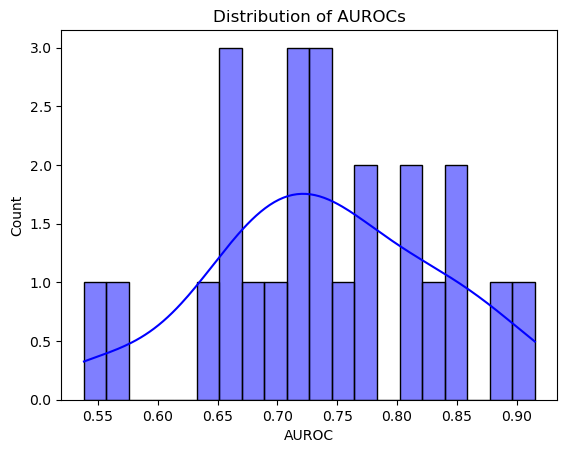

In [30]:
ranked_debug_plots(
    evaluations_df_lr,
    walch_data_bundle.activity.numpy(),
    walch_data_bundle.true_labels.numpy(),
    predictors,
    lr_cnn_pred_proba,
    walch_data_bundle.spectrogram.numpy(),
    "_lr_cnn_eval",
    "lr",
    walch_keys
)

# Triplots

## Tri plot for UNet

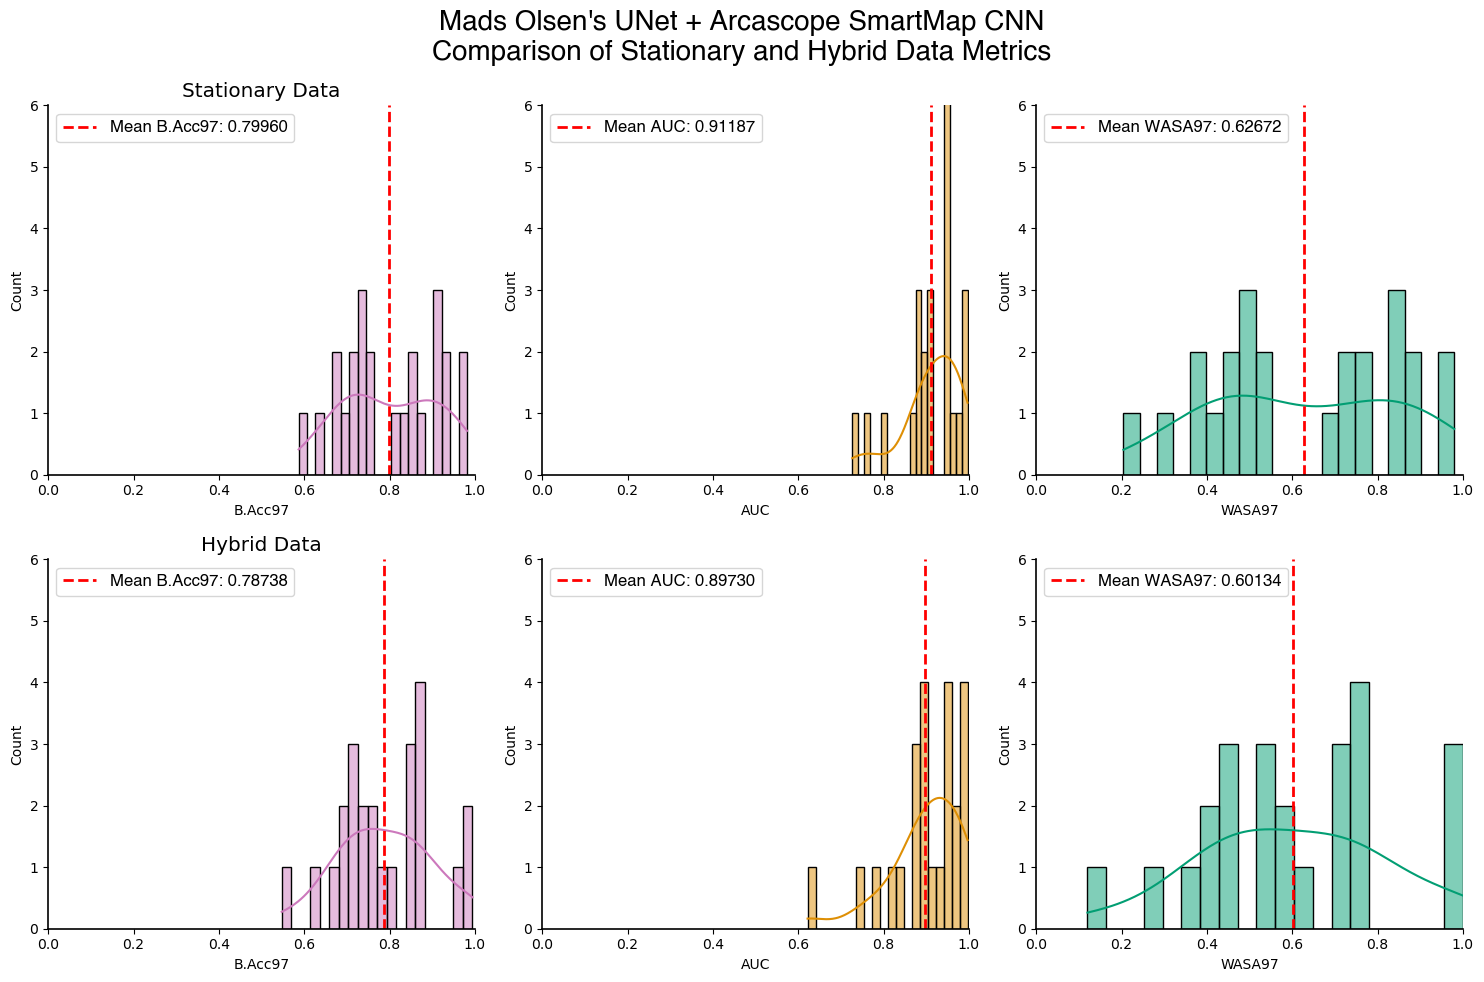

In [31]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

tri_plot_metrics(evaluations_df, axs=axs[0], axs_set_name="Stationary Data")
tri_plot_metrics(evaluations_df_hybrid, axs=axs[1], axs_set_name="Hybrid Data")

for ax in axs.flatten():
    ax.set_ylim(0, 6)

fig.suptitle("Mads Olsen's UNet + Arcascope SmartMap CNN\nComparison of Stationary and Hybrid Data Metrics", fontsize=20)

fig.tight_layout()
fig.savefig(Path(os.getcwd()).joinpath(f"smartmap_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=600, bbox_inches='tight')
# fig.savefig(Path(os.getcwd()).joinpath("comparison_metrics_triplot.png"), dpi=600, bbox_inches='tight')

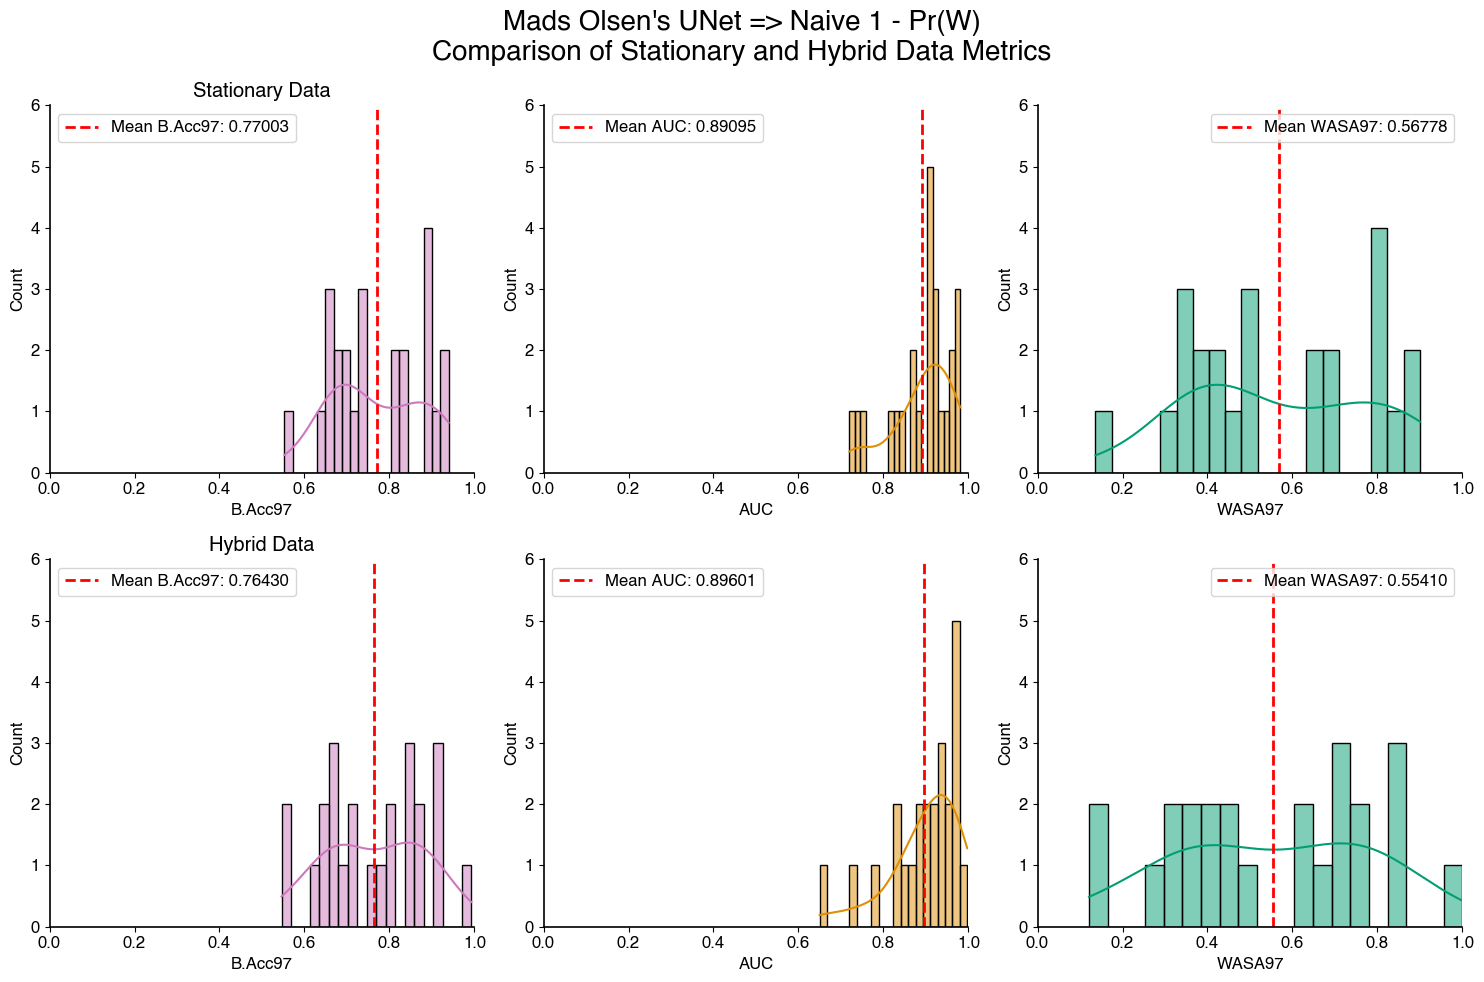

In [32]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

tri_plot_metrics(evaluations_df_naive_walch, axs=axs[0], axs_set_name="Stationary Data")
tri_plot_metrics(evaluations_df_naive_hybrid, axs=axs[1], axs_set_name="Hybrid Data")

for ax in axs.flatten():
    ax.set_ylim(0, 6)

fig.suptitle("Mads Olsen's UNet => Naive 1 - Pr(W)\nComparison of Stationary and Hybrid Data Metrics", fontsize=20)

fig.tight_layout()
fig.savefig(Path(os.getcwd()).joinpath(f"naive_mo_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=600, bbox_inches='tight')
# fig.savefig(Path(os.getcwd()).joinpath("comparison_metrics_triplot.png"), dpi=600, bbox_inches='tight')

## Tri plot for logistic regression CNN

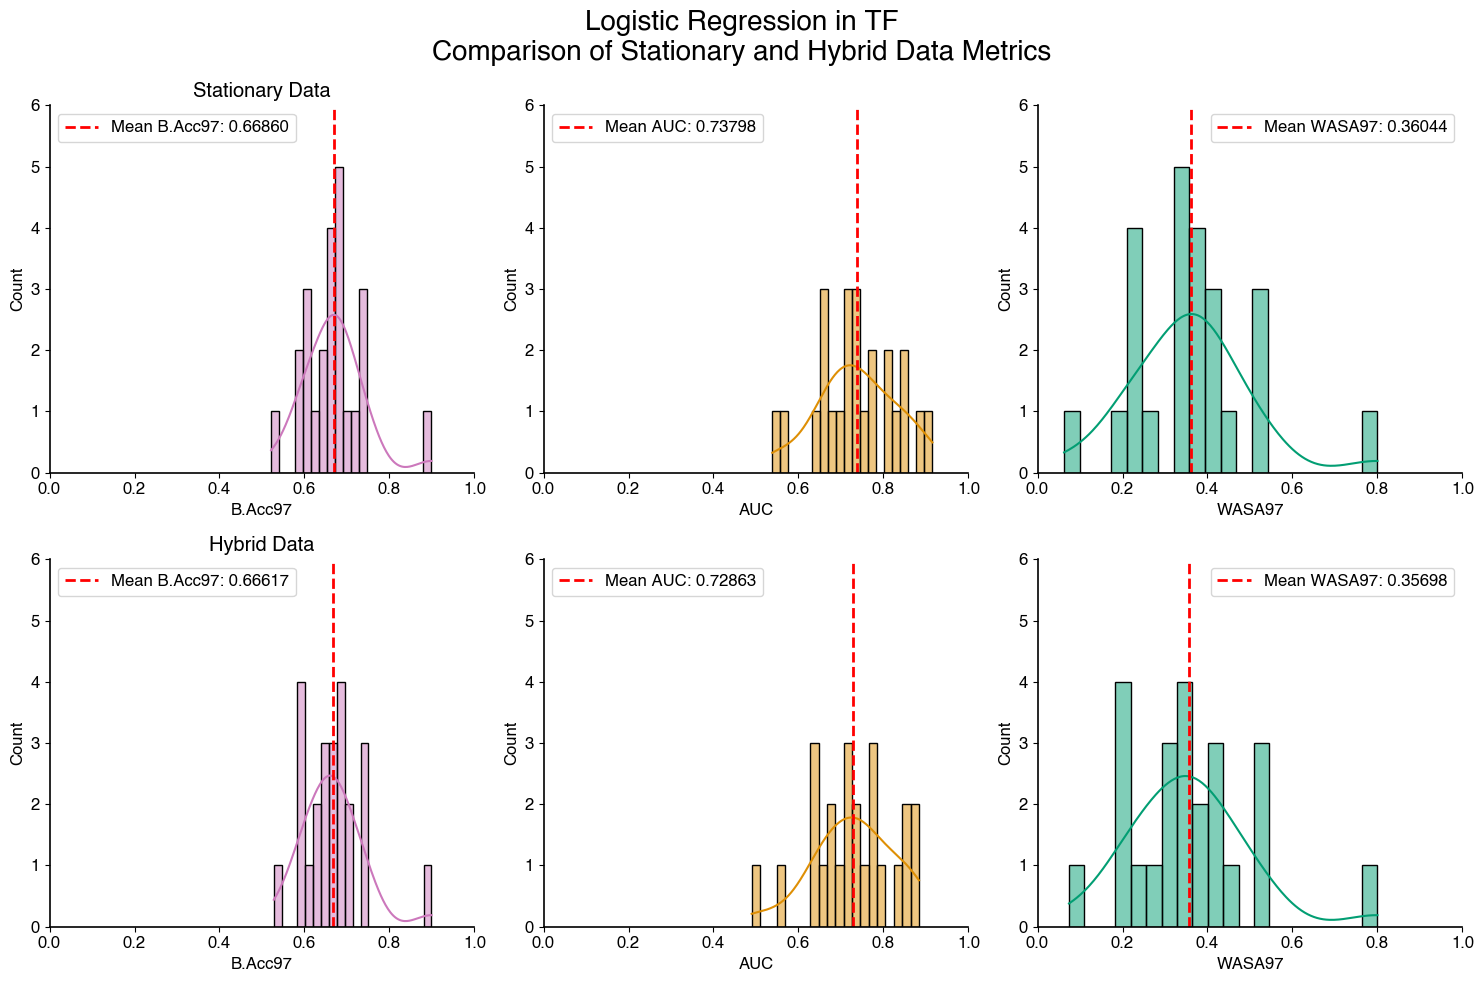

In [33]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))

tri_plot_metrics(evaluations_df_lr, axs=axs[0], axs_set_name="Stationary Data")
tri_plot_metrics(evaluations_df_lr_hybrid, axs=axs[1], axs_set_name="Hybrid Data")

for ax in axs.flatten():
    ax.set_ylim(0, 6)

fig.suptitle("Logistic Regression in TF\nComparison of Stationary and Hybrid Data Metrics", fontsize=20)

fig.tight_layout()
fig.savefig(Path(os.getcwd()).joinpath(f"lr_cnn_triplot_{WASA_SLEEP_PERCENT}.png"), dpi=600, bbox_inches='tight')